# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name: Edward

Last Name: Kang

Student ID: 912655433

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

In [19]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, MultiPoint
import shapefile
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.patches import Circle, Wedge, Polygon
%matplotlib inline


sqlite_file = '/Users/Edward/sf_data.sqlite'
db = sqlite3.connect(sqlite_file)

query = """select p.Applicant,
           count(s.locationid) as 'Unique Locations', Status
           from mobile_food_permits p
           inner join mobile_food_schedule s on p.permit = s.permit
           where p.Status = 'APPROVED'
           group by Applicant
           order by count(s.locationid)
           desc
        """
                                  
most_location_food_ven =  pd.read_sql_query(query,db)
most_location_food_ven.head(1)

,Applicant,Unique Locations,Status
0,Park's Catering,134,APPROVED


  The Park's Catering sells at 134 locations which are the most.

__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

# 1.Which parts of the city are the most and least expensive?

In [7]:
query = """select "RegionName",
           avg("MedianSoldPricePerSqft_AllHomes") as Avg_PricePerSqft 
           from zillow 
           where "MedianSoldPricePerSqft_AllHomes"!=' ' group by "RegionName" 
           order by avg("MedianSoldPricePerSqft_AllHomes")
        """
price = pd.read_sql_query(query,db)
price.tail(1)

,RegionName,Avg_PricePerSqft
25,94104,1336.128581


In [8]:
price.head(1)

,RegionName,Avg_PricePerSqft
0,94124,297.008046


[Text(0,0.5,'Prce Per Sauare Feet'), Text(0.5,0,'Area Zip Code')]

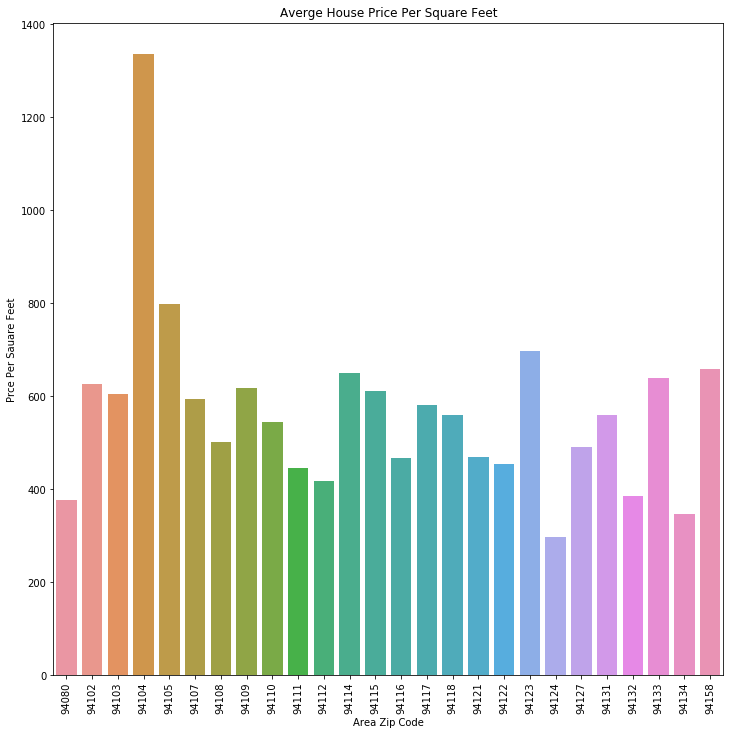

In [11]:
plt.rcParams['figure.figsize'] = (12, 12)
Price_Per_Sqft = sns.barplot(x = price['RegionName'], y = price['Avg_PricePerSqft'], data = price)
for item in Price_Per_Sqft.get_xticklabels():
    item.set_rotation(90)
plt.title('Averge House Price Per Square Feet')
Price_Per_Sqft.set(ylabel = 'Prce Per Sauare Feet', xlabel = 'Area Zip Code')

  The 94104 region is the most expensive part of the city with $1336.13 price per square feet. The reason is because it is in the downtown area of San Francisco. This area is colse to many popular places such as Union Square, Chinatown, shopping centers, museums and piers, so it is very convenient to go shopping and eating. Furthermore this area is near the finacial district so it is colse to many big companies. Many emplyess would like to rent the houses in this area. Since this type of houses are easy to rent out so the price will be high. Moreover, there is a BART station near this area, so the price will be even higher. 

  The 94124 region is the least expensive part of the city with $297.01 price per square feet. The reason is because it is the edge area of San Francisco. It is far away from big shopping centers, working areas, and universities.

# 2.Which parts of the city are the most dangerous (and at what times)?

In [12]:
query = """select Lon, Lat, PdDistrict, strftime('%H', Datetime) as 'Hour of the Day', count(*) as 'PdDistCount'
           from crime
           where PdDistrict is not null
           group by PdDistrict, Datetime
           order by count(*)
           desc
        """
crime_time = pd.read_sql_query(query,db)
crime_time.head(20)

,Lon,Lat,PdDistrict,Hour of the Day,PdDistCount
0,-122.402672,37.756423,BAYVIEW,00,48
1,-122.404286,37.796142,CENTRAL,11,35
2,-122.422063,37.789920,NORTHERN,12,34
3,-122.476057,37.762657,TARAVAL,12,34
4,-122.408761,37.715900,INGLESIDE,00,26
5,-122.401817,37.788441,SOUTHERN,12,26
6,-122.403405,37.775421,SOUTHERN,00,23
7,-122.397251,37.778980,SOUTHERN,00,22
8,-122.474308,37.716643,TARAVAL,12,22
9,-122.419059,37.759423,MISSION,00,21


  We count how many times a PdDistrict appears in different areas for each hour of the day. This will show us which areas have the most amount of crimes and between what hours the most crime occurs. We see that most of the crimes happened at night during the time 10 p.m to 12 a.m. The parts of the city that are most dangerous are Bayview, Central, Taraval, Northern, Southern and Ingleside.

In [29]:
query = """select Lon, Lat, PdDistrict, COUNT(*) as 'PdDistCount'
           from crime
           where PdDistrict is not null
           group by PdDistrict, Lon
           order by count(*)
           desc
           LIMIT 2000
        """
crime_location = pd.read_sql_query(query,db)
crime_location.head()

,Lon,Lat,PdDistrict,PdDistCount
0,-122.403405,37.775421,SOUTHERN,30673
1,-122.406539,37.756486,MISSION,4631
2,-122.419672,37.765050,MISSION,4580
3,-122.407634,37.784189,SOUTHERN,4410
4,-122.419658,37.764221,MISSION,3497


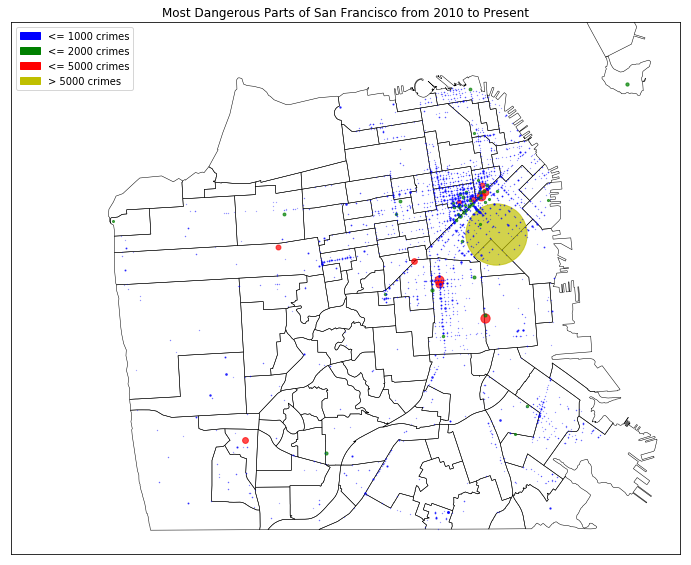

In [14]:
query = """select Lon, Lat, PdDistrict, COUNT(*) as 'PdDistCount'
           from crime
           where PdDistrict is not null
           group by PdDistrict, Lon
           order by count(*)
           desc
           LIMIT 2000
        """
crime_location = pd.read_sql_query(query,db)
crime_location.columns = crime_location.columns.str.lower()

plt.rcParams['figure.figsize'] = (12, 12)
my_map = Basemap(resolution='i',projection='merc',llcrnrlat=37.7026, urcrnrlat=37.8236, llcrnrlon=-122.5430, urcrnrlon=-122.3503)
my_map.readshapefile("geo_export_774df04a-ae3b-4906-9331-c3a929c411f4", "sfneighborhoods")
for longi, lata, dist in zip(crime_location.lon, crime_location.lat, crime_location.pddistcount):
    x, y = my_map(longi, lata)
    dot_size = dist / 500
    if dist <= 1000:
        color = "b"
    elif dist <= 2000:
        color = "g"
    elif dist <= 5000:
        color = "r"
    else:
        color = "y"
    my_map.plot(x, y, color + "o", markersize = dot_size, alpha = 0.7)
    
b_patch = mpatches.Patch(color='b', label='<= 1000 crimes')
g_patch = mpatches.Patch(color='g', label='<= 2000 crimes')
r_patch = mpatches.Patch(color='r', label='<= 5000 crimes')
y_patch = mpatches.Patch(color='y', label='> 5000 crimes')
plt.title('Most Dangerous Parts of San Francisco from 2010 to Present')
plt.legend(handles=[b_patch, g_patch, r_patch, y_patch])

  From the map we can see most of the crimes happened in Mission Bay area. Also, a lot of small crimes happened near downtown areas maybe due to these areas have a large population of tourists and high-middle class. Criminals aimed those kind of wealthy people. Moreover, large amount of homeless people stay in thses areas can also be the reason that more crimes happened.

# 3. Are noise complaints and mobile food vendors related?

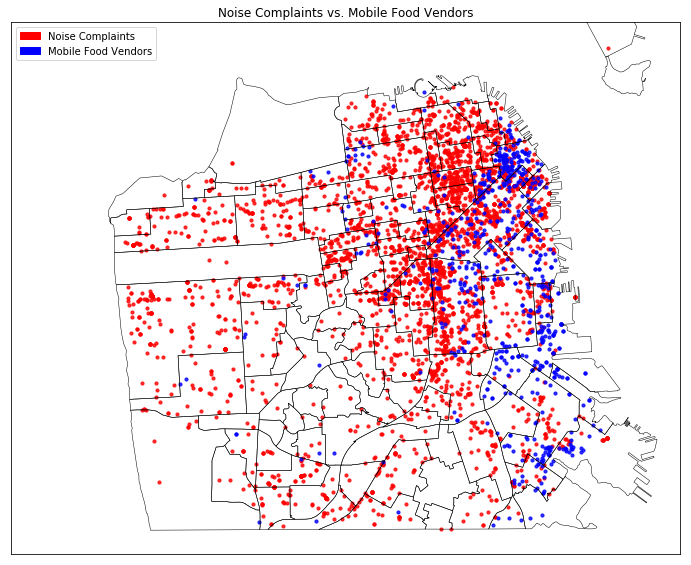

In [22]:
query ="""select "Lat" as lat,"Lon" as lon 
          from noise 
          where lat != '' 
          and lon != '' 
        """
noise = pd.read_sql_query(query,db)

query ="""select "Latitude" as lat, "Longitude" as lon 
          from mobile_food_locations
        """
food_ven = pd.read_sql_query(query,db)

plt.rcParams['figure.figsize'] = (12, 12)
cmap = Basemap(llcrnrlat=37.7026, urcrnrlat=37.8236, llcrnrlon=-122.5430, urcrnrlon=-122.3503,
               resolution='i',projection='merc')
cmap.readshapefile("geo_export_774df04a-ae3b-4906-9331-c3a929c411f4",'noise_food_ven')
x1,y1 = cmap(list(noise.lon),list(noise.lat))
x2,y2 = cmap(list(food_ven.lon),list(food_ven.lat))
cmap.scatter(x1,y1,s=10,c='r',marker="o",cmap=cm.jet,alpha=0.8,)
cmap.scatter(x2,y2,s=10,c='b',marker="o",cmap=cm.jet,alpha=0.8,)

plt.title('Noise Complaints vs. Mobile Food Vendors')
red_patch = mpatches.Patch(color='red', label='Noise Complaints')
blue_patch = mpatches.Patch(color='blue', label='Mobile Food Vendors')
plt.legend(handles=[red_patch, blue_patch])

  From the map the bule dots are mobile food vendors and the red dots are noise complaints. We can see many noise complaints are not near the mobile food vendors. While in downtown areas some of the red dots are close to the blue dots does not mean noise complaints and mobile food verdors are related. There are many night clubs and bars in downtown areas, this maybe one of the reason of noise complaints. Therefore, in my opinion, noise complaints and mobile food veendors are not related.

# 4.What are the best times and places to find food trucks?

In [23]:
query = """select "Address" as address,"DayOfWeek" as weekday, "EndHour" as end, "StartHour" as start, 
           count(*) as count from mobile_food_schedule 
           join mobile_food_locations on mobile_food_schedule.locationid = mobile_food_locations.locationid 
           join mobile_food_permits on mobile_food_schedule.permit = mobile_food_permits.permit 
           where "FacilityType" == 'Truck'
           group by Address, weekday
           order by count 
           desc
        """
food_truck = pd.read_sql_query(query,db)
food_truck.head(11)

,address,weekday,end,start,count
0,400 HOWARD ST,Th,14,11,8
1,400 HOWARD ST,Tu,14,11,8
2,Assessors Block /Lot,Mo,11,10,8
3,400 HOWARD ST,Fr,17,16,7
4,400 HOWARD ST,Mo,17,16,7
5,400 HOWARD ST,We,14,11,7
6,1 SANSOME ST,Fr,15,11,4
7,1 SANSOME ST,Mo,15,11,4
8,1 SANSOME ST,Th,15,11,4
9,1 SANSOME ST,Tu,15,11,4


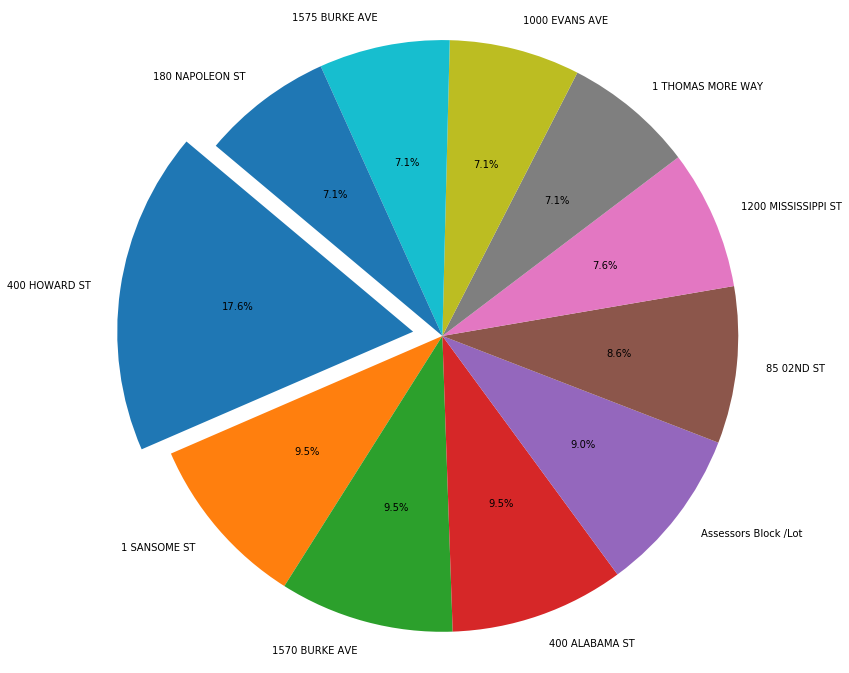

In [26]:
query = """select "Address" as address,
           count(*) as count from mobile_food_schedule 
           join mobile_food_locations on mobile_food_schedule.locationid = mobile_food_locations.locationid 
           join mobile_food_permits on mobile_food_schedule.permit = mobile_food_permits.permit 
           where "FacilityType" == 'Truck'
           group by Address
           order by count 
           desc
        """
food_truck1 = pd.read_sql_query(query,db)
plt.pie(food_truck1.head(11)['count'], explode = (0.1,0,0,0,0,0,0,0,0,0,0),labels=food_truck1.head(11)['address'],autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

  We can see the best places to find food truscks is at 400 Howard St from Monday through Friday around 11 a.m. to 3 p.m. From the pie char we can see 400 Howard St has about 9% more numbers of food trucks than the average numbers of food truck in other top 11 places. This location is in downtown. We know that during Monday through Friday at 11 a.m. to 3 p.m many people are out of lunch in this area. Many of them may choose food trucks due to food trucks are fast and cheap. Also downtown areas are densely-populated areas, so food trucks choose those areas and timing to do more businesses and have a better earning. Therefroe, 400 Howard St from Monday through Friday around 11 a.m. to 3 p.m. is the best time to find food truck.

# 5. Are schools and house price related?

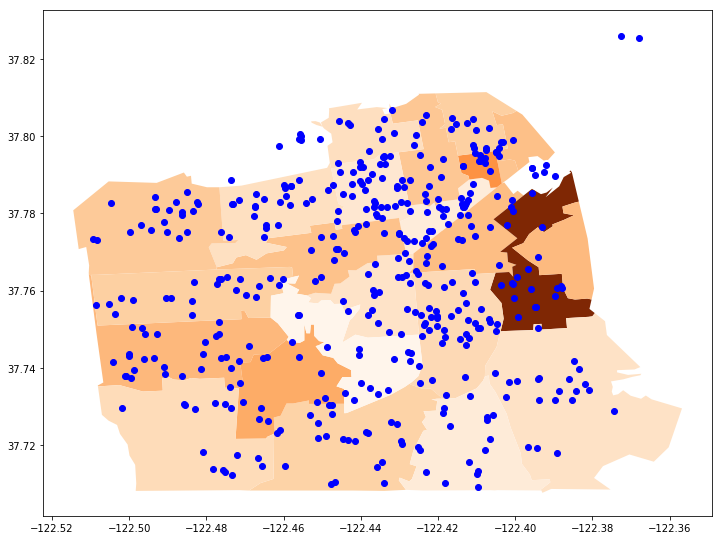

In [80]:
query ="""select * from schools
       """
schools = pd.read_sql_query(query, db)

schools.columns = schools.columns.str.lower()
zips_of_SF = gpd.read_file("cb_2016_us_zcta510_500k.shp")
zipcodes = pd.read_sql("SELECT RegionName FROM zillow GROUP BY RegionName", db)
zipcodes = [str(zips) for zips in zipcodes["RegionName"].values]

south_zip = ['94105', '94080']
for zipcode in south_zip:
    zipcodes.remove(zipcode)

zips_of_SF = zips_of_SF.loc[zips_of_SF["ZCTA5CE10"].isin(set(all_zipcodes))]
zips_of_SF = zips_of_SF.sort_values("ZCTA5CE10").reset_index(drop=True)
zips_of_SF = zips_of_SF[["ZCTA5CE10", "geometry"]]
price = price.sort_values("RegionName").reset_index(drop=True)
df = pd.concat([zips_of_SF, price["Avg_PricePerSqft"]], axis=1)

my_map = df.plot(column='Avg_PricePerSqft', cmap="Oranges")
schools = plt.scatter(schools["lon"], schools["lat"], marker='o', color = 'blue')

  We plot the map of house average price per square feet. The darker the color is means the house price is higher. Moreover, the blue dots mean the locations of the schools. From the map we can see there is no relationship between the number of school and house price. We can see one of the highest house price region only has a few schools.While the white color region in the middle also has a similar number of schools. Most of the schools are located in downtown areas which it does make sense since downtown is a highly populated areas. In my opinion, schools distrubution maybe more related to population in the areas.